In [1]:
# 1: 라이브러리 임포트 및 사용자 설정
# --- 기본 라이브러리 ---
import os
import glob
import time
import pandas as pd
import numpy as np

# --- PDF 처리, AI/ML 및 시각화 ---
import fitz  # PyMuPDF
from openai import OpenAI
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- 토큰 계산기 ---
try:
    import tiktoken
    ENC = tiktoken.get_encoding("cl100k_base")
    USING_TIKTOKEN = True
except ImportError:
    USING_TIKTOKEN = False
    print("경고: tiktoken 라이브러리를 찾을 수 없습니다. 글자 수 기반으로 청크를 분할합니다.")

In [2]:
# --------- API 클라이언트 초기화 ---------
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY가 설정되어 있지 않습니다.")

client = OpenAI()

# 예시 사용
response = client.chat.completions.create(
    model="gpt-4.1-mini",  
    messages=[{"role": "user", "content": "너는 어떤 모델인지 간단하게 답변해줘"}]
)

print(response.choices[0].message.content)

저는 OpenAI가 개발한 GPT-4 기반의 언어 모델입니다. 다양한 주제에 대해 자연스러운 대화를 나누고 질문에 답변할 수 있어요.


In [3]:
# 클러스터 갯수 지정
while True:
    try:
        k_input = input("분석할 클러스터의 개수를 숫자로 입력하세요 (예: 5): ")
        K_CLUSTERS = int(k_input)
        if K_CLUSTERS > 1:
            break
        else:
            print("오류: 클러스터 개수는 2 이상이어야 합니다.")
    except ValueError:
        print("오류: 유효한 숫자를 입력해주세요.")

# --- 기타 설정 ---
PAPER_DIRECTORY = "/Users/snu.sim/git/ai-chatbot-tasks/task(6)/paper"
MODEL = "text-embedding-3-small"
MAX_TOKENS_PER_CHUNK = 750
CHUNK_OVERLAP_TOKENS = 50
BATCH_SIZE = 64

print(f"설정 완료: K_CLUSTERS={K_CLUSTERS}, PAPER_DIRECTORY='{PAPER_DIRECTORY}'")

설정 완료: K_CLUSTERS=5, PAPER_DIRECTORY='/Users/snu.sim/git/ai-chatbot-tasks/task(6)/paper'


In [4]:
# 2: PDF 문서 처리 및 임베딩 생성
print("PDF 텍스트 추출 및 임베딩(청크/배치) 생성을 시작합니다.")

# --- Helper 함수 정의 ---

def get_pdf_title(doc, fallback_filename: str) -> str:
    """PDF 문서 객체에서 제목을 추출합니다. (메타데이터 > 내용 > 파일명 순)"""
    # 1순위: 메타데이터에서 제목 추출
    if doc.metadata and doc.metadata.get('title'):
        title = doc.metadata['title'].strip()
        # 일반적인 무의미한 제목 제외
        if len(title) > 5 and not title.lower().startswith(('untitled', 'microsoft word')):
            return title
    
    # 2순위: 첫 페이지 상단 텍스트로 추정 (Heuristic)
    if len(doc) > 0:
        try:
            # 첫 페이지의 텍스트 블록들을 세로 위치(y1) 기준으로 정렬
            blocks = doc[0].get_text("blocks")
            blocks.sort(key=lambda b: b[1])
            
            potential_title = ""
            # 상위 3개 텍스트 블록까지 확인하여 제목 조합
            for block in blocks[:3]:
                line_text = block[4].replace('\n', ' ').strip()
                if len(line_text) > 2: # 너무 짧은 줄은 제외
                    potential_title += " " + line_text
                    if len(potential_title) > 200: # 제목이 너무 길어지면 중단
                        break
            
            potential_title = potential_title.strip()
            if len(potential_title) > 5:
                return potential_title
        except Exception:
            pass # 페이지 분석 중 오류 발생 시 다음 단계로 넘어감

    # 3순위: 위 방법 실패 시, 파일명을 정리하여 사용
    return os.path.splitext(fallback_filename)[0].replace('_', ' ').replace('-', ' ').strip()

def split_into_chunks(text: str) -> list[str]:
    """텍스트를 토큰 기준의 청크로 분할합니다."""
    if USING_TIKTOKEN:
        tokens = ENC.encode(text)
        chunks = []
        start = 0
        while start < len(tokens):
            end = min(start + MAX_TOKENS_PER_CHUNK, len(tokens))
            chunks.append(ENC.decode(tokens[start:end]))
            if end == len(tokens): break
            start = end - CHUNK_OVERLAP_TOKENS
        return chunks
    else: # Fallback for when tiktoken is not available
        approx_chars = MAX_TOKENS_PER_CHUNK * 3.5
        approx_overlap = CHUNK_OVERLAP_TOKENS * 3.5
        chunks = []
        start, N = 0, len(text)
        while start < N:
            end = min(start + int(approx_chars), N)
            chunks.append(text[start:end])
            if end == N: break
            start = max(0, end - int(approx_overlap))
        return chunks

def embed_batch(text_list: list[str], model: str = MODEL, retry: int = 3) -> list[list[float]]:
    """텍스트 목록을 배치 처리하여 임베딩을 생성합니다."""
    for attempt in range(retry):
        try:
            resp = client.embeddings.create(input=text_list, model=model)
            return [d.embedding for d in resp.data]
        except Exception as e:
            print(f"API 호출 오류 (시도 {attempt + 1}/{retry}): {e}. {2**attempt}초 후 재시도합니다.")
            if attempt >= retry - 1: raise
            time.sleep(2 ** attempt)
    return []


# --- 1) PDF → 텍스트 (강화된 제목 추출 적용) ---
filepaths = glob.glob(os.path.join(PAPER_DIRECTORY, "*.pdf"))
papers_data = []
for path in filepaths:
    try:
        doc = fitz.open(path)
        title = get_pdf_title(doc, os.path.basename(path))
        text = " ".join(page.get_text("text").replace('\n', ' ').strip() for page in doc)
        if text: # 내용이 있는 경우에만 추가
            papers_data.append({"title": title, "text": text})
        doc.close()
    except Exception as e:
        print(f"오류: '{os.path.basename(path)}' 파일 처리 중 문제 발생 - {e}")

df = pd.DataFrame(papers_data)
if df.empty:
    raise SystemExit(f"'{PAPER_DIRECTORY}'에서 처리할 PDF 파일을 찾지 못했습니다. 프로그램을 중단합니다.")
print(f"총 {len(df)}개 문서에서 텍스트와 제목을 추출했습니다.")


# --- 2) 텍스트 → 청크 ---
chunk_rows = []
for _, row in df.iterrows():
    chunks = split_into_chunks(row["text"])
    for i, chunk in enumerate(chunks):
        chunk_rows.append({"title": row["title"], "chunk_id": i, "text": chunk})

df_chunks = pd.DataFrame(chunk_rows)
if df_chunks.empty:
    raise SystemExit("생성된 청크가 없습니다. 원문 텍스트를 확인하세요. 프로그램을 중단합니다.")
print(f"임베딩 대상 청크 수: {len(df_chunks)}개")


# --- 3) 청크 → 임베딩 (배치 처리) ---
embeddings = []
texts = df_chunks["text"].tolist()
for i in range(0, len(texts), BATCH_SIZE):
    batch_texts = texts[i:i+BATCH_SIZE]
    batch_embeddings = embed_batch(batch_texts)
    embeddings.extend(batch_embeddings)
    print(f"- 진행률: {min(i + BATCH_SIZE, len(texts))}/{len(texts)}")

df_chunks["embedding"] = embeddings
print("임베딩 생성 완료.")

PDF 텍스트 추출 및 임베딩(청크/배치) 생성을 시작합니다.
총 36개 문서에서 텍스트와 제목을 추출했습니다.
임베딩 대상 청크 수: 752개
- 진행률: 64/752
- 진행률: 128/752
- 진행률: 192/752
- 진행률: 256/752
- 진행률: 320/752
- 진행률: 384/752
- 진행률: 448/752
- 진행률: 512/752
- 진행률: 576/752
- 진행률: 640/752
- 진행률: 704/752
- 진행률: 752/752
임베딩 생성 완료.


In [5]:
# 3: 클러스터링 및 결과 분석
# --- K-Means 클러스터링 (청크 기준) ---
embedding_matrix = np.array(df_chunks["embedding"].tolist())
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto')
df_chunks["cluster"] = kmeans.fit_predict(embedding_matrix)
print("청크 단위 클러스터링 완료.")

# --- 논문별 대표 클러스터 할당 (다수결 방식) ---
# 각 논문에 속한 청크들이 가장 많이 포함된 클러스터를 해당 논문의 대표 클러스터로 선정
doc_clusters = df_chunks.groupby('title')['cluster'].apply(lambda x: x.mode()[0]).reset_index()
doc_clusters.rename(columns={'cluster': 'main_cluster'}, inplace=True)
print("논문별 대표 클러스터 할당 완료.")

# ===================================================================
# 요구사항 2: 각 논문의 제목과 클러스터링 결과를 함께 출력
# ===================================================================
print("\n--- [결과 1] 논문별 클러스터링 할당 결과 ---")
print(doc_clusters)

# ===================================================================
# 요구사항 1: 각 클러스터에 속한 논문 목록을 출력
# ===================================================================
print("\n--- [결과 2] 클러스터별 논문 목록 ---")
for i in range(K_CLUSTERS):
    print(f"\n[ 클러스터 {i} ]")
    titles = doc_clusters[doc_clusters['main_cluster'] == i]['title'].tolist()
    if titles:
        for title in titles:
            print(f"- {title}")
    else:
        print("(해당 클러스터에 속한 논문이 없습니다.)")

청크 단위 클러스터링 완료.
논문별 대표 클러스터 할당 완료.

--- [결과 1] 논문별 클러스터링 할당 결과 ---
                                                title  main_cluster
0   A Density-Based Algorithm for Discovering Clus...             3
1          Adam: A Method for Stochastic Optimization             3
2   An Analysis of the Impact of Gold Open Access ...             2
3   Analysis of Research Trends in Computer Scienc...             2
4   Auto-Encoding Variational Bayes Diederik P. Ki...             3
5   BERT: Pre-training of Deep Bidirectional Trans...             4
6   Batch Normalization: Accelerating Deep Network...             0
7        Deep Residual Learning for Image Recognition             0
8   Diamond open access and open infrastructures  ...             2
9   Distinctive Image Features from Scale-Invarian...             3
10  Efﬁcient Estimation of Word Representations in...             4
11  FAIR and Open Computer Science Research Softwa...             2
12  Fast R-CNN Ross Girshick Microsoft Research r


--- [결과 3] 클러스터링 결과 2D 시각화 ---


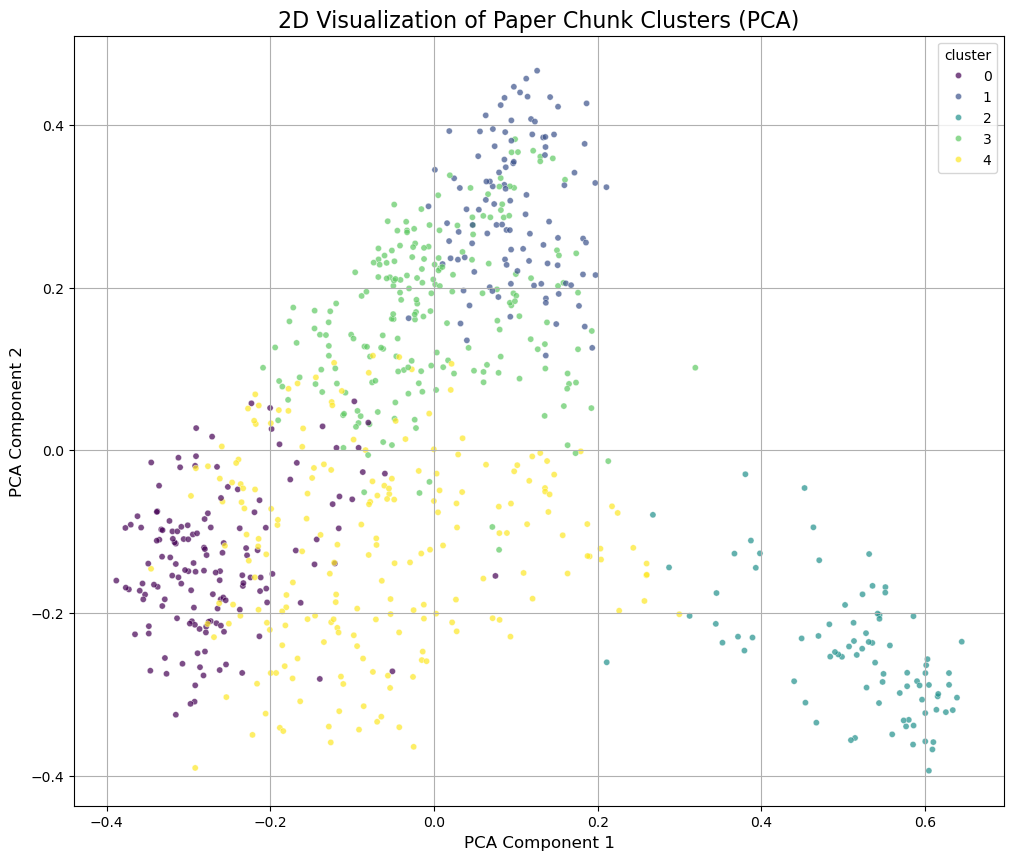

In [6]:
# 4: 결과 시각화
# ===================================================================
# 요구사항 4: 클러스터링 결과를 2D로 시각화
# ===================================================================
print("\n--- [결과 3] 클러스터링 결과 2D 시각화 ---")

# --- PCA 차원 축소 ---
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(embedding_matrix)
df_chunks['pca1'] = pca_result[:,0]
df_chunks['pca2'] = pca_result[:,1]

# --- 시각화 (영문) ---
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='pca1', y='pca2',
    hue='cluster',
    palette='viridis',
    data=df_chunks,
    legend='full',
    alpha=0.7,
    s=20
)
plt.title('2D Visualization of Paper Chunk Clusters (PCA)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.grid(True)
plt.show()